# Post-processing of case studies

## Usage notes

All figures will be written to the directory `img` as pdf and png files.

It will look for results in a "simulation/<simulator>" folder on the same level as this notebook. Simulators currently supported: "dymola", "optimica"

## Import required libraries

In [1]:
import os
import cases

import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from buildingspy.io.outputfile import Reader
from buildingspy.io.postprocess import Plotter

## Load in simulation results

In [2]:
# Helper methods

def get_results(case_name, simulator = "dymola"):
    """ Get the results for the case with name `case_name`
    from a "simulation/<simulator>" folder.

    Parameters:
    
        simulator: str
            "optimica" or "dymola"

    Returns:

        Reader: buildingspy.io.outputpy.Reader instance
    """
    if simulator not in ["dymola", "optimica"]:
        raise Exception("Unsupported simulator provided.")

    # First make sure that the simulation was successful

    # For results generated using Dymola
    if simulator == "dymola":

        dslog_name = os.path.join("simulations", simulator, case_name, "dslog.txt")
        with open(dslog_name) as dslog:
            if not "Integration terminated successfully" in dslog.read():
                raise Exception("Simulation failed. Check {}".format(dslog_name))

    # For results generated using Optimica
    elif simulator == "optimica":

        for file in os.listdir(os.path.join("simulations", simulator, case_name)):
            if '.json' in file:
                json_log_fullpath = os.path.join("simulations", simulator, case_name, file)
                import json
                if not json.load(open(json_log_fullpath))["translation"]["success"]:
                    raise Exception("Simulation failed. Check {}".format(json_log_fullpath))
    
    else:
        raise Exception("Simulation log found for neither supported simulation engine.")

    file_name = cases.get_result_fullpath(case_name, simulator)

    return Reader(file_name, simulator)


def get_partial_results(case_name, list_of_variables, simulator = "dymola", 
                        as_dataframe = False, equidistant = False):
    """ Get a dictionary with the variable names and the time series for `list_of_variables`

    Parameters:
    
        case_name: str
            Name of the simulated case

        list_of_variables: list
            Variable names for which to extract the result data

        simulator: str
            "optimica" or "dymola" 

        as_dataframe: bool
            If all variables have the same time record in the output one may convert the 
            resulting dictionary into a dataframe
            
        equidistant: bool
            Adds a column with the timestep size, if the results are with
            an equidistant timestep (no events).

    Returns:

        d: dataframe or dict
            holds time and varable for each variable listed in list_of_variables
    """
    reader = get_results(case_name, simulator = simulator)
    d = dict()
    for v in list_of_variables:
        try:
            d['time_' + v] = reader.values(v)[0]
            d[v] = reader.values(v)[1]
        except:
            print("Variable {} not found in case {} for simulator {}".format(v, case_name, simulator))

    if as_dataframe:
        import pandas as pd
        d = pd.DataFrame(d)
        if equidistant:
            d['ts_duration_min'] = pd.Series(
                d['time_' + list_of_variables[0]][1:].values - d[
                    'time_' + list_of_variables[0]][:-1].values).unique()[0]/60

    return d

In [3]:
# Read in all simulation results

all_case_names = cases.get_list_of_case_names()
print("Found cases:", all_case_names)

res = {"optimica" : dict(), "dymola" : dict()}
simulators = ["dymola", "optimica"]

res = {"dymola" : dict()}
simulators = ["dymola"]

for simulator in simulators:
    for case_name in all_case_names:
        res[simulator][case_name] = get_results(case_name, simulator)

print("Read in simulation results.")

Found cases: ['base_summer', 'base_2loop_summer', '1711_heapreval_summer', '1711_wse_summer', '1711_heapreval_wse_summer', '1711_heapreval_wse_sta_summer', '1711_all_summer', 'base_annual', 'base_2loop_annual', '1711_heapreval_annual', '1711_wse_annual', '1711_heapreval_wse_annual', '1711_heapreval_wse_sta_annual', '1711_all_annual']
Read in simulation results.


In [4]:
(t,var) = res[simulator]["1711_heapreval_wse_summer"].values('TZonSupSet')
var

array([300.15, 300.15], dtype=float32)

## Explore variables found in the simulation results

In [5]:
# aggregate data timeseries

PAgg = {"dymola": dict(), "optimica": dict()}
simulators = ["dymola", "optimica"]
for simulator in simulators:
    for case in all_case_names:
        PAgg[simulator][case] = get_partial_results(
            case,  ["PConWatPumAgg.y", "PWSEWatPumAgg.y", "PChiWatPumAgg.y", "PChiAgg.y", "PCooTowAgg.y", "PSupFanAgg.y","QRooIntGaiAgg.y"], 
            simulator, as_dataframe=True, equidistant = simulator == "dymola")
        PAgg[simulator][case] = PAgg[simulator][case].loc[(PAgg[simulator][case].index % 2)==0,:].reset_index(drop=True)

Variable PWSEWatPumAgg.y not found in case base_summer for simulator dymola
Variable PWSEWatPumAgg.y not found in case 1711_heapreval_summer for simulator dymola
Variable PWSEWatPumAgg.y not found in case 1711_wse_summer for simulator dymola
Variable PWSEWatPumAgg.y not found in case 1711_heapreval_wse_summer for simulator dymola
Variable PWSEWatPumAgg.y not found in case 1711_heapreval_wse_sta_summer for simulator dymola
Variable PWSEWatPumAgg.y not found in case 1711_all_summer for simulator dymola
Variable PWSEWatPumAgg.y not found in case base_annual for simulator dymola
Variable PWSEWatPumAgg.y not found in case 1711_heapreval_annual for simulator dymola
Variable PWSEWatPumAgg.y not found in case 1711_wse_annual for simulator dymola
Variable PWSEWatPumAgg.y not found in case 1711_heapreval_wse_annual for simulator dymola
Variable PWSEWatPumAgg.y not found in case 1711_heapreval_wse_sta_annual for simulator dymola
Variable PWSEWatPumAgg.y not found in case 1711_all_annual for simul

In [6]:
PAgg["dymola"]['base_annual'].head(10)
PAgg["dymola"]['base_2loop_summer'].head(20)

,time_PConWatPumAgg.y,PConWatPumAgg.y,time_PWSEWatPumAgg.y,PWSEWatPumAgg.y,time_PChiWatPumAgg.y,PChiWatPumAgg.y,time_PChiAgg.y,PChiAgg.y,time_PCooTowAgg.y,PCooTowAgg.y,time_PSupFanAgg.y,PSupFanAgg.y,time_QRooIntGaiAgg.y,QRooIntGaiAgg.y,ts_duration_min
0,14688000.0,0.0,14688000.0,0.0,14688000.0,0.0,14688000.0,0.0,14688000.0,0.0,14688000.0,0.000000e+00,14688000.0,0.000000e+00,12.666667
1,14689520.0,7183935.5,14689520.0,4931662.5,14689520.0,2920915.5,14689520.0,34211056.0,14689520.0,8666138.0,14689520.0,6.452279e+07,14689520.0,7.600000e+08,12.666667
2,14691040.0,20779418.0,14691040.0,28357060.0,14691040.0,6096865.5,14691040.0,44202420.0,14691040.0,17786138.0,14691040.0,1.290456e+08,14691040.0,1.520000e+09,12.666667
3,14692560.0,34374900.0,14692560.0,51782456.0,14692560.0,9272815.0,14692560.0,53731756.0,14692560.0,26906138.0,14692560.0,1.935684e+08,14692560.0,2.280000e+09,12.666667
4,14694080.0,47970380.0,14694080.0,75207856.0,14694080.0,12448765.0,14694080.0,62892612.0,14694080.0,36026136.0,14694080.0,2.580912e+08,14694080.0,3.040000e+09,12.666667
5,14695600.0,61565864.0,14695600.0,98633248.0,14695600.0,15624715.0,14695600.0,71764504.0,14695600.0,45146136.0,14695600.0,3.226140e+08,14695600.0,3.800000e+09,12.666667
6,14697120.0,75161344.0,14697120.0,122058648.0,14697120.0,18800666.0,14697120.0,80433928.0,14697120.0,54266136.0,14697120.0,3.871368e+08,14697120.0,4.560000e+09,12.666667
7,14698640.0,88756832.0,14698640.0,145484048.0,14698640.0,21976616.0,14698640.0,88911568.0,14698640.0,63386136.0,14698640.0,4.516596e+08,14698640.0,5.320000e+09,12.666667
8,14700160.0,102352312.0,14700160.0,168909440.0,14700160.0,25152564.0,14700160.0,97213992.0,14700160.0,72506136.0,14700160.0,5.161823e+08,14700160.0,6.080000e+09,12.666667
9,14701680.0,115947792.0,14701680.0,192334832.0,14701680.0,28328514.0,14701680.0,105426632.0,14701680.0,81626136.0,14701680.0,5.807052e+08,14701680.0,6.840000e+09,12.666667


In [7]:
PAgg["dymola"]['base_annual'].tail()/(1000*3600)

,time_PConWatPumAgg.y,PConWatPumAgg.y,time_PChiWatPumAgg.y,PChiWatPumAgg.y,time_PChiAgg.y,PChiAgg.y,time_PCooTowAgg.y,PCooTowAgg.y,time_PSupFanAgg.y,PSupFanAgg.y,time_QRooIntGaiAgg.y,QRooIntGaiAgg.y,ts_duration_min
5396,8.753511,114377.304747,8.753511,13380.567040,8.753511,33468.447858,8.753511,52521.064676,8.753511,371579.617280,8.753511,4.374256e+06,0.000014
5397,8.755133,114401.735111,8.755133,13382.002916,8.755133,33468.447858,8.755133,52530.799502,8.755133,371648.466489,8.755133,4.375067e+06,0.000014
5398,8.756756,114426.165476,8.756756,13383.396693,8.756756,33468.447858,8.756756,52540.534329,8.756756,371717.315698,8.756756,4.375878e+06,0.000014
5399,8.758378,114450.595840,8.758378,13384.838258,8.758378,33468.447858,8.758378,52550.264604,8.758378,371786.201316,8.758378,4.376689e+06,0.000014
5400,8.760000,114475.026204,8.760000,13386.241138,8.760000,33468.447858,8.760000,52559.999431,8.760000,371855.050524,8.760000,4.377500e+06,0.000014


In [8]:
500000 * 8760/(1000)/1000/290

15.10344827586207

In [9]:
PAgg["dymola"]['1711_wse_annual'].head(20)

,time_PConWatPumAgg.y,PConWatPumAgg.y,time_PChiWatPumAgg.y,PChiWatPumAgg.y,time_PChiAgg.y,PChiAgg.y,time_PCooTowAgg.y,PCooTowAgg.y,time_PSupFanAgg.y,PSupFanAgg.y,time_QRooIntGaiAgg.y,QRooIntGaiAgg.y,ts_duration_min
0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,48.666667
1,5840.0,6.987505e+07,5840.0,1.355932e+06,5840.0,0.0,5840.0,35040000.0,5840.0,2.479034e+08,5840.0,2.368572e+08,48.666667
2,11680.0,1.578212e+08,11680.0,2.661342e+06,11680.0,0.0,11680.0,70080000.0,11680.0,4.958067e+08,11680.0,9.473905e+08,48.666667
3,17520.0,2.457674e+08,17520.0,3.966752e+06,17520.0,0.0,17520.0,105120000.0,17520.0,7.437101e+08,17520.0,2.131613e+09,48.666667
4,23360.0,3.337136e+08,23360.0,5.272162e+06,23360.0,0.0,23360.0,140160000.0,23360.0,9.916134e+08,23360.0,3.789524e+09,48.666667
5,29200.0,4.216598e+08,29200.0,6.633012e+06,29200.0,0.0,29200.0,175200000.0,29200.0,1.239517e+09,29200.0,5.921124e+09,48.666667
6,35040.0,5.096060e+08,35040.0,8.750554e+06,35040.0,0.0,35040.0,210240000.0,35040.0,1.487420e+09,35040.0,8.526413e+09,48.666667
7,40880.0,5.975521e+08,40880.0,1.182301e+07,40880.0,0.0,40880.0,245280000.0,40880.0,1.735324e+09,40880.0,1.144001e+10,48.666667
8,46720.0,6.854983e+08,46720.0,1.539966e+07,46720.0,0.0,46720.0,280320000.0,46720.0,1.983227e+09,46720.0,1.436001e+10,48.666667
9,52560.0,7.734445e+08,52560.0,1.958869e+07,52560.0,0.0,52560.0,315360000.0,52560.0,2.231130e+09,52560.0,1.728001e+10,48.666667


In [10]:
data = {"dymola": dict(), "optimica": dict()}
simulators = ["dymola", "optimica"]

for simulator in simulators:
    
    for case in all_case_names:
        if "1711_heapreval_" in case and "_wse_" not in case: 
            var_labels = ["weaBus.TWetBul", "pumCW.m_flow", "chilledWaterReset.uChiWatPlaRes","chilledWaterReset.TChiWatSupSet","chilledWaterReset.dpChiWatPumSet", "pumCW.VMachine_flow", "pumCW.eta", "pumCW.y", "pumCW.P", "TAirSup.T", "chi.on", "waterSideEconomizerOnOff.yOn"]
        elif "_wse_" in case or '1711_all' in case:
            var_labels = ["weaBus.TWetBul", "pumCW.m_flow", "chilledWaterReset.uChiWatPlaRes","chilledWaterReset.TChiWatSupSet","chilledWaterReset.dpChiWatPumSet", "pumCW.VMachine_flow", "pumCW.eta","pumCW.P","TAirSup.T", "chi.on", "yWSEOn.y"]
        else:
            var_labels = ["weaBus.TWetBul", "pumCW.m_flow", "chilledWaterReset.uChiWatPlaRes","chilledWaterReset.TChiWatSupSet","chilledWaterReset.dpChiWatPumSet", "pumCW.VMachine_flow", "pumCW.P", "pumCW.eta","TAirSup.T", "chi.on", "waterSideEconomizerOnOff.yOn"]

        if "1711_heapreval_" in case:
            var_labels += ["pumCW.y"]
            
        if "1711_all_" in case:
            var_labels += ["cooTow.y", "heaPreCon.yHeaPreConVal", "pumCW.y","chi.m1_flow"]
            
        var_labels += ["chi.PLR2", "chi.PLR1", "chi.P", "chi.TEvaLvg", "chi.TEvaEnt", "chi.TConLvg", "chi.TConEnt"]
            
        data[simulator][case] = get_partial_results(
            case,  var_labels, simulator, as_dataframe=True)
        
        data[simulator][case] = data[simulator][case].loc[(data[simulator][case].index % 2)==0,:].reset_index(drop=True)
        data[simulator][case] = data[simulator][case][data[simulator][case].columns.drop(list(data[simulator][case].filter(regex='time_')))]
        
data["dymola"]['1711_heapreval_wse_annual'].columns

Index(['weaBus.TWetBul', 'pumCW.m_flow', 'chilledWaterReset.uChiWatPlaRes',
       'chilledWaterReset.TChiWatSupSet', 'chilledWaterReset.dpChiWatPumSet',
       'pumCW.VMachine_flow', 'pumCW.eta', 'pumCW.P', 'TAirSup.T', 'chi.on',
       'yWSEOn.y', 'pumCW.y', 'chi.PLR2', 'chi.PLR1', 'chi.P', 'chi.TEvaLvg',
       'chi.TEvaEnt', 'chi.TConLvg', 'chi.TConEnt'],
      dtype='object')

In [11]:
data["dymola"]['1711_all_annual'].describe()

,weaBus.TWetBul,pumCW.m_flow,chilledWaterReset.uChiWatPlaRes,chilledWaterReset.TChiWatSupSet,chilledWaterReset.dpChiWatPumSet,pumCW.VMachine_flow,pumCW.eta,pumCW.P,TAirSup.T,chi.on,...,heaPreCon.yHeaPreConVal,pumCW.y,chi.m1_flow,chi.PLR2,chi.PLR1,chi.P,chi.TEvaLvg,chi.TEvaEnt,chi.TConLvg,chi.TConEnt
count,5401.000000,5401.000000,5401.000000,5401.000000,5401.000000,5401.000000,5401.00,5401.000000,5401.000000,5401.000000,...,5401.000000,5401.0,5401.000000,5401.000000,5401.000000,5401.000000,5401.000000,5401.000000,5401.000000,5401.000000
mean,284.301239,38.637093,0.603072,291.750061,129630.984375,0.038808,0.49,12217.429688,300.146637,0.455656,...,0.173187,1.0,6.191957,0.093613,0.093478,6795.756348,291.006653,294.013336,295.151001,290.806671
std,4.598301,1.520868,0.033290,0.977848,2583.554688,0.001528,0.00,292.224426,0.174848,0.498076,...,0.259373,0.0,6.957537,0.103582,0.103498,7518.085449,0.762006,1.574179,1.321604,1.868789
min,271.574585,37.271030,0.000000,281.382172,25940.000000,0.037436,0.49,11677.042969,289.710785,0.000000,...,0.000000,1.0,0.000180,0.000000,0.000000,0.000000,289.753479,284.332703,291.175568,282.738953
25%,280.849396,37.271030,0.576639,290.718140,129700.000000,0.037436,0.49,11954.693359,300.149994,0.000000,...,0.000000,1.0,0.000180,0.000000,0.000000,0.000000,290.718140,292.630066,295.098724,289.165985
50%,284.469421,37.271030,0.576736,292.626923,129700.000000,0.037436,0.49,12477.285156,300.149994,0.000000,...,0.000000,1.0,0.000180,0.000000,0.000000,0.000000,290.718964,292.630127,295.699249,289.166046
75%,287.524445,40.068378,0.634789,292.630127,129700.000000,0.040246,0.49,12477.285156,300.149994,1.000000,...,0.261554,1.0,12.469502,0.195805,0.195805,14293.340820,290.747406,295.433563,295.718170,292.472260
max,296.183411,41.233055,0.918730,295.149994,129700.000000,0.041416,0.49,12477.285156,300.870850,1.000000,...,1.000000,1.0,18.995909,0.359264,0.359264,27534.484375,293.149994,299.508148,301.528748,297.565521


### Sizing considerations

In [12]:
# aggregate data timeseries

data_df = {"dymola": dict()}
simulators = ["dymola"]
for simulator in simulators:
    for case in all_case_names:
        data_df[simulator][case] = get_partial_results(
            case,  ["chi.COP", "chi.TSet", "chilledWaterReset.TChiWatSupSet", "chilledWaterReset.uChiWatPlaRes", "chi.TEvaLvg", "chi.TEvaEnt", "chi.TConLvg", "chi.TConEnt", "weaBus.TWetBul"], 
            simulator, as_dataframe=True, equidistant = simulator == "dymola")
        
        data_df[simulator][case] = data_df[simulator][case].loc[(data_df[simulator][case].index % 2)==0,:].reset_index(drop=True)
        data_df["dymola"][case] = data_df["dymola"][case][data_df["dymola"][case].columns.drop(list(data_df["dymola"][case].filter(regex='time_')))]

In [13]:
print(data_df["dymola"]["base_annual"].describe().round(2))
# data_df["dymola"]["base_annual"].loc[(data_df["dymola"]["base_annual"]["chilledWaterReset.TChiWatSupSet"] > 288) & (data_df["dymola"]["base_annual"]["chilledWaterReset.TChiWatSupSet"] < 291),:]
print((data_df["dymola"]["base_annual"]["chilledWaterReset.uChiWatPlaRes"] > 0.8).sum())
print((data_df["dymola"]["base_annual"]["chilledWaterReset.uChiWatPlaRes"] <= 0.8).sum())
data_df["dymola"]["base_annual"].shape

       chi.COP  chi.TSet  chilledWaterReset.TChiWatSupSet  \
count  5401.00   5401.00                          5401.00   
mean      5.14    293.24                           293.24   
std       5.95      2.19                             2.19   
min       0.00    290.69                           290.69   
25%       0.00    290.72                           290.72   
50%       0.00    295.15                           295.15   
75%      11.58    295.15                           295.15   
max      13.82    295.15                           295.15   

       chilledWaterReset.uChiWatPlaRes  chi.TEvaLvg  chi.TEvaEnt  chi.TConLvg  \
count                          5401.00      5401.00      5401.00      5401.00   
mean                              0.40       291.19       291.05       287.82   
std                               0.21         1.34         3.07         4.75   
min                               0.00       290.61       279.10       277.39   
25%                               0.20       

(5401, 10)

In [14]:
# print(data["dymola"]["1711_all_annual"].describe().round(2))

chi_on_1711 = data["dymola"]["1711_all_annual"][data["dymola"]["1711_all_annual"]["chi.on"]>0]

chi_on_base = data["dymola"]["base_annual"][data["dymola"]["base_annual"]["chi.on"]>0]

print(chi_on_base.describe().round(2))

       weaBus.TWetBul  pumCW.m_flow  chilledWaterReset.uChiWatPlaRes  \
count         2318.00       2318.00                          2318.00   
mean           288.43         39.68                             0.63   
std              2.61          0.00                             0.00   
min            284.03         39.68                             0.63   
25%            286.36         39.68                             0.63   
50%            288.08         39.68                             0.63   
75%            290.44         39.68                             0.63   
max            296.18         39.68                             0.64   

       chilledWaterReset.TChiWatSupSet  chilledWaterReset.dpChiWatPumSet  \
count                          2318.00                            2318.0   
mean                            290.72                          129700.0   
std                               0.00                               0.0   
min                             290.69         

In [15]:
print(chi_on_1711.describe().round(2))

       weaBus.TWetBul  pumCW.m_flow  chilledWaterReset.uChiWatPlaRes  \
count         2461.00       2461.00                          2461.00   
mean           288.19         40.27                             0.63   
std              2.73          0.43                             0.00   
min            283.27         39.69                             0.63   
25%            286.03         40.06                             0.63   
50%            287.85         40.07                             0.63   
75%            290.26         40.11                             0.63   
max            296.18         41.23                             0.69   

       chilledWaterReset.TChiWatSupSet  chilledWaterReset.dpChiWatPumSet  \
count                          2461.00                           2461.00   
mean                            290.72                         129699.99   
std                               0.04                              0.00   
min                             288.95         

### Some statistics

In [16]:
# to add months to equidistant data

df = data["dymola"]['base_annual']
df['12 bins'] = list(df.index/(5401/12))
df['12 bins'] = np.ceil(df['12 bins'])

count_wse_on_per_month = df.groupby('12 bins').sum()["waterSideEconomizerOnOff.yOn"].reset_index()

# df.index

# list(df.index/12)

# base_annual = df[df["chi.on"] != 1.][df["waterSideEconomizerOnOff.yOn"] == 1.]
df1 = data["dymola"]['1711_wse_annual']
# wse_annual = df1[df1["chi.on"] != 1.][df1["yWSEOn.y"] == 1.]
# df2 = data["dymola"]['1711_heapreval_wse_annual']
# cwreset_wse_annual = df2[df2["chi.on"] != 1.][df2["yWSEOn.y"] == 1.]

# print(base_annual.shape)
# print(wse_annual.shape)
# print(cwreset_wse_annual.shape)

count_wse_on_per_month
df1["yWSEOn.y"].sum()

5401.0

In [17]:
pd.options.display.float_format = '{:,.2f}'.format

data1 = data.copy()

for case in all_case_names:
    data1["dymola"][case] = data["dymola"][case][data["dymola"][case].columns.drop(list(data["dymola"][case].filter(regex='time_')))]

for case in all_case_names:
    print("\n {case_name}, simulation averages: \n".format(case_name = case))

    print(data1["dymola"][case].mean())
    print("\nChiller ON % of time", data1["dymola"][case].mean()["chi.on"])
    try:
        print("WSE ON % of time", data1["dymola"][case].mean()["waterSideEconomizerOnOff.yOn"])
        print("Data records where WSE is on and chiller is not:", data1["dymola"][case].loc[
            :, "waterSideEconomizerOnOff.yOn"].sum() - sum(data1["dymola"][case].loc[
            :, "waterSideEconomizerOnOff.yOn"] == data1["dymola"][case].loc[:, "chi.on"]))
    except:
        print("WSE ON % of time", data1["dymola"][case].mean()["yWSEOn.y"])
        print("Data records where WSE is on and chiller is not:", data1["dymola"][case].loc[
            :, "yWSEOn.y"].sum() - sum(data1["dymola"][case].loc[
            :, "yWSEOn.y"] == data1["dymola"][case].loc[:, "chi.on"]))


 base_summer, simulation averages: 

weaBus.TWetBul                         288.76
pumCW.m_flow                            39.68
chilledWaterReset.uChiWatPlaRes          0.62
chilledWaterReset.TChiWatSupSet        290.95
chilledWaterReset.dpChiWatPumSet   127,674.35
pumCW.VMachine_flow                      0.04
pumCW.P                             10,656.07
pumCW.eta                                0.49
TAirSup.T                              300.13
chi.on                                   0.95
waterSideEconomizerOnOff.yOn             1.00
chi.PLR2                                 0.20
chi.PLR1                                 0.14
chi.P                                9,655.15
chi.TEvaLvg                            290.72
chi.TEvaEnt                            294.06
chi.TConLvg                            292.32
chi.TConEnt                            290.76
dtype: float32

Chiller ON % of time 0.9461211
WSE ON % of time 0.99981487
Data records where WSE is on and chiller is not: 289.0

 ba

In [18]:
# data1["dymola"]["1711_all_annual"][data1["dymola"]["1711_all_annual"]["cooTow.y"]<=0.2]
# data1["dymola"]["base_annual"][data1["dymola"]["base_annual"]["cooTow.y"]==0.]

# Compile total energy use per device, case, and simulator

## Energy use

We obtain the energy use as cumulative power consumed by:

- Zone supply fan: fan.P
- Chilled water pump: pumCHW.P
- Condenser water pump: pumCW.P
- Chiller: chi.P
- Cooling tower: cooTow.PFan

We also look at the aggregate IT Heat Load

In [19]:
vlmap = {
    "PConWatPumAgg.y" : "CW Pump [kWh]",
    "PWSEWatPumAgg.y" : "WSE Pump [kWh]",
    "PChiWatPumAgg.y" : "CHW Pump [kWh]",
    "PChiAgg.y" : "Chiller [kWh]",
    "PCooTowAgg.y" : "Cooling Tower Fan [kWh]",
    "PSupFanAgg.y" : "Supply Fan [kWh]",
    "QRooIntGaiAgg.y" : "IT Heat Load [kWh]"
}

# Season: use value from the case dist

# Controller design: use long name of the case dict

# *mg add season later

# PAgg_compiled = pd.DataFrame(columns = [["Simulator", "Controller Design", "Season"] + list(vlmap.values())])
PAgg_compiled = pd.DataFrame()

inx = 0

for simulator in simulators:
    for case in cases.get_cases():
        PAgg_compiled.loc[inx, "Simulator"] = simulator
        PAgg_compiled.loc[inx, "Controller Design"] = case['long_name'][:-8]
        PAgg_compiled.loc[inx, "Season"] = case['season']
        for var in list(vlmap.keys()):
            # grab the last value in the cumulative result variables and convert to kWh from Ws
            try:
                PAgg_compiled.loc[inx, vlmap[var]] = (PAgg[simulator][case['name']].loc[:,var][-1:].values[0]/(1000*3600)).round(1)
            except:
                PAgg_compiled.loc[inx, vlmap[var]] = np.nan

        inx += 1
        
PAgg_compiled["Total Energy Use [kWh]"] = PAgg_compiled.loc[:,vlmap['PConWatPumAgg.y'] : vlmap["PSupFanAgg.y"]].sum(axis = 1)

In [20]:
PAgg_compiled

,Simulator,Controller Design,Season,CW Pump [kWh],WSE Pump [kWh],CHW Pump [kWh],Chiller [kWh],Cooling Tower Fan [kWh],Supply Fan [kWh],IT Heat Load [kWh],Total Energy Use [kWh]
0,dymola,Base-case,summer,"24,305.30",nan,"4,693.60","22,022.90","13,680.00","96,784.20","1,140,000.00","161,486.00"
1,dymola,Base-case w 2 CW loops,summer,"20,292.20","35,062.20","4,759.00","32,265.90","13,679.90","96,784.20","1,140,000.00","202,843.40"
2,dymola,Adds head pressure valve modulation,summer,"27,289.60",nan,"4,683.20","21,565.20","13,678.20","96,784.20","1,140,000.00","164,000.40"
3,dymola,Uses alternative WSE on/off,summer,"24,343.10",nan,"4,690.80","21,998.40","13,680.00","96,784.20","1,140,000.00","161,496.50"
4,dymola,Adds head pressure valve modulation and uses a...,summer,"27,280.50",nan,"4,688.60","22,116.90","13,680.00","96,784.20","1,140,000.00","164,550.20"
5,dymola,"Head pressure valve modulation, alternative WS...",summer,"27,279.60",nan,"4,692.40","22,100.70","13,680.00","96,784.20","1,140,000.00","164,536.90"
6,dymola,Alternative,summer,"27,221.20",nan,"4,789.20","28,714.00","7,025.90","96,784.20","1,140,000.00","164,534.50"
7,dymola,Base-case,annual,"114,475.00",nan,"13,386.20","33,468.40","52,560.00","371,855.10","4,377,500.10","585,744.70"
8,dymola,Base-case w 2 CW loops,annual,"46,606.90","112,371.30","15,035.60","57,640.60","52,559.00","371,855.10","4,377,500.10","656,068.50"
9,dymola,Adds head pressure valve modulation,annual,"107,444.80",nan,"13,162.20","32,357.60","52,559.10","371,855.10","4,377,500.10","577,378.80"


## Energy performance metrics: PUE

## For the plant

In [21]:
pue_df = PAgg_compiled.loc[:, ["Total Energy Use [kWh]", vlmap["QRooIntGaiAgg.y"]]].copy()
pue_only =pd.DataFrame()

pue_df["PUE"] = pue_df.sum(axis = 1.).divide(pue_df[vlmap["QRooIntGaiAgg.y"]])

pue_only["PUE"] = pue_df.sum(axis = 1.).divide(pue_df[vlmap["QRooIntGaiAgg.y"]])

pue_df["Simulator"] = PAgg_compiled["Simulator"].copy()
pue_df["Controller Design"] = PAgg_compiled["Controller Design"].copy()

pue_only["Simulator"] = PAgg_compiled["Simulator"].copy()
pue_only["Controller Design"] = PAgg_compiled["Controller Design"]
# pue_df
# pue_only = 
# pue_df.loc[:, "PUE", "Simulator", "Controller Design"]
pue_only["Season"] = PAgg_compiled["Season"].copy()
pue_only

,PUE,Simulator,Controller Design,Season
0,1.14,dymola,Base-case,summer
1,1.18,dymola,Base-case w 2 CW loops,summer
2,1.14,dymola,Adds head pressure valve modulation,summer
3,1.14,dymola,Uses alternative WSE on/off,summer
4,1.14,dymola,Adds head pressure valve modulation and uses a...,summer
5,1.14,dymola,"Head pressure valve modulation, alternative WS...",summer
6,1.14,dymola,Alternative,summer
7,1.13,dymola,Base-case,annual
8,1.15,dymola,Base-case w 2 CW loops,annual
9,1.13,dymola,Adds head pressure valve modulation,annual


## PUE per device (DPUE)

This metric, device-resolution PUE (DPUE) I define as follows:

* x - total energy use excluding the IT energy use
* y - total IT energy use (we assumed it converts to heat in the room)
* x1 - device energy use

DPUE_x1 = x1/y + x1/x

Then the sum of all devices thus matches the wiki formula for PUE = (x + y)/y

With this the stacked colors represent devices and the total bar hight the system PUE.

In [22]:
pue_df_per_device = PAgg_compiled.loc[:, "CW Pump [kWh]":"Supply Fan [kWh]"].copy()
pue_df_per_device = pue_df_per_device.divide(PAgg_compiled[vlmap["QRooIntGaiAgg.y"]], axis = 0) + pue_df_per_device.divide(PAgg_compiled["Total Energy Use [kWh]"], axis = 0)
pue_df_per_device["System PUE"] = pue_df_per_device.sum(axis = 1.)

# PAgg_compiled[vlmap["QRooIntGaiAgg.y"]]
pue_df_per_device["Simulator"] = PAgg_compiled["Simulator"].copy()
pue_df_per_device["Controller Design"] = PAgg_compiled["Controller Design"]
pue_df_per_device["Season"] = PAgg_compiled["Season"].copy()

# remove unit from column labels
cols = [c[:-6] for c in pue_df_per_device.columns[:-4]]

rename_dict = dict()
for i in np.arange(len(cols)):
    rename_dict[pue_df_per_device.columns[i]] = cols[i]

pue_df_per_device = pue_df_per_device.rename(columns = rename_dict)
pue_df_per_device

,CW Pump,WSE Pump,CHW Pump,Chiller,Cooling Tower Fan,Supply Fan,System PUE,Simulator,Controller Design,Season
0,0.17,nan,0.03,0.16,0.10,0.68,1.14,dymola,Base-case,summer
1,0.12,0.20,0.03,0.19,0.08,0.56,1.18,dymola,Base-case w 2 CW loops,summer
2,0.19,nan,0.03,0.15,0.10,0.68,1.14,dymola,Adds head pressure valve modulation,summer
3,0.17,nan,0.03,0.16,0.10,0.68,1.14,dymola,Uses alternative WSE on/off,summer
4,0.19,nan,0.03,0.15,0.10,0.67,1.14,dymola,Adds head pressure valve modulation and uses a...,summer
5,0.19,nan,0.03,0.15,0.10,0.67,1.14,dymola,"Head pressure valve modulation, alternative WS...",summer
6,0.19,nan,0.03,0.20,0.05,0.67,1.14,dymola,Alternative,summer
7,0.22,nan,0.03,0.06,0.10,0.72,1.13,dymola,Base-case,annual
8,0.08,0.20,0.03,0.10,0.09,0.65,1.15,dymola,Base-case w 2 CW loops,annual
9,0.21,nan,0.03,0.06,0.10,0.73,1.13,dymola,Adds head pressure valve modulation,annual


## Total energy use and PUE comparative plots

In [23]:
df_en_use = pd.melt(PAgg_compiled, id_vars=["Simulator", "Controller Design", "Season"], value_vars = vlmap.values(), var_name="Device", value_name='Energy Use [kWh]')

device_cols = ["CW Pump","WSE Pump", "CHW Pump","Chiller","Cooling Tower Fan","Supply Fan"]

df_dpue = pd.melt(pue_df_per_device, id_vars=["Simulator", "Controller Design", "Season"], value_vars = device_cols, var_name="Device", value_name='PUE')
df_dpue

,Simulator,Controller Design,Season,Device,PUE
0,dymola,Base-case,summer,CW Pump,0.17
1,dymola,Base-case w 2 CW loops,summer,CW Pump,0.12
2,dymola,Adds head pressure valve modulation,summer,CW Pump,0.19
3,dymola,Uses alternative WSE on/off,summer,CW Pump,0.17
4,dymola,Adds head pressure valve modulation and uses a...,summer,CW Pump,0.19
...,...,...,...,...,...
79,dymola,Adds head pressure valve modulation,annual,Supply Fan,0.73
80,dymola,Uses alternative WSE on/off,annual,Supply Fan,0.72
81,dymola,Adds head pressure valve modulation and uses a...,annual,Supply Fan,0.73
82,dymola,"Head pressure valve modulation, alternative WS...",annual,Supply Fan,0.73


In [24]:
# using matplotlib

# from matplotlib import cm
# cmap = cm.get_cmap('Spectral')

# plot1 = PAgg_compiled.loc[:,:vlmap['PSupFanAgg.y']].set_index(['Controller Design', 'Simulator']).plot(
#     kind='bar', x = None, stacked=True,
#     title = "Power consumption per device, controller design, and simulator, in kWh",
#     rot = 90, cmap=cmap, width=.3, grid=False).legend(loc='upper right')

# # plot1 = ax.spines["right"]
# # plot1.set_visible(False)

# fig1 = plot1.get_figure()
# fig1.set_size_inches(6, 8)
# fig1.tight_layout()
# fig1.savefig("img/energy_use.png", bbox_inches='tight')

# plot2 = pue_only.set_index(['Controller Design', 'Simulator']).plot(
#     kind='bar', x = None, stacked=False,
#     title = "PUE",
#     rot = 90, cmap=cmap, width=.3, grid=False).legend(loc='upper right')

# fig2 = plot2.get_figure()
# fig2.set_size_inches(4, 8)
# fig2.tight_layout()
# fig2.savefig("img/pue.png", bbox_inches='tight')

In [25]:
# obtain some hex colors

import plotly.express as px

print(px.colors.qualitative.Plotly)

['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52']


## Energy use

In [26]:
# energy use, using plotly

from plotly.offline import iplot, init_notebook_mode

import plotly.graph_objs as go
import plotly.io as pio

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16,
        'color' : "#7f7f7f"}

width = 600
height = 1600

df = df_en_use.copy()

for sim in df["Simulator"].unique():
    
    title = sim.capitalize()
    
    df_s = df[df["Simulator"] == sim]

    fig = go.Figure()

    fig.update_layout(
        template="simple_white",
#         xaxis=dict(title_text="Season, Controller Design"),
#         yaxis=dict(title_text="Energy Use [kWh]"),
        barmode="stack",
        font=dict(family=font['family'], size=font['size']),
        title=title,
        titlefont=dict(size=font['size'] * 2.0, family=font['family']),
        xaxis=dict(
            title_text="Season, Controller Design",
            titlefont=dict(
                family=font['family'],
                size=font['size'],
                color=font['color'],
            ),
            tickfont=dict(size=font['size']),
        ),
        yaxis=dict(
            title_text="Energy Use [kWh]",
            titlefont=dict(
                family=font['family'],
                size=font['size'],
                color=font['color'],
            ),
            tickfont=dict(size=font['size']),
        ),
        showlegend=True,
        width=width,
        height=height,
#         margin=dict(l=margin_l, b=margin_b),
        legend=dict(
            x=0,
            y=1,
            font=dict(family=font['family'], size=font['size']*.8),
        ),
    )


#     colors = ["#2A66DE", "#FFC32B", "#339933", "#cc9900", "#9933cc"]
    colors = ['#636EFA', '#37FDFC', '#EF553B', '#00CC96', '#AB63FA', '#FECB52']

    for r, c in zip(df_s["Device"].unique(), colors):
        plot_df = df_s[df_s["Device"] == r]
        fig.add_trace(
            go.Bar(x=[plot_df["Season"].apply(lambda x: x.capitalize()), plot_df["Controller Design"]], y=plot_df["Energy Use [kWh]"], name=r, marker_color=c, width = 0.5),
        )

    img_bytes = fig.to_image(format="png", engine="kaleido")
    
    filename = "energy_use_" + sim

    pio.write_image(fig, os.path.join("img", filename + ".png"))

    pio.write_image(fig, os.path.join("img", filename + ".pdf"))

    from IPython.display import Image
    Image(img_bytes)
    

In [ ]:
df_dpue

### PUE device level and total PUI all-in-one

In [32]:
# data is from df_dpue

df = df_dpue.copy()

from plotly.offline import iplot, init_notebook_mode

import plotly.graph_objs as go
import plotly.io as pio

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16,
        'color' : "#7f7f7f"}

width = 600
height = 1000

for sim in df["Simulator"].unique():
    
    title = sim.capitalize()
    
    df_s = df[df["Simulator"] == sim]

    fig = go.Figure()

    fig.update_layout(
        template="simple_white",
#         xaxis=dict(title_text="Season, Controller Design"),
#         yaxis=dict(title_text="Energy Use [kWh]"),
        barmode="stack",
        font=dict(family=font['family'], size=font['size']),
        title=title,
        titlefont=dict(size=font['size'] * 1.0, family=font['family']),
        xaxis=dict(
            title_text="Season, Controller Design",
            titlefont=dict(
                family=font['family'],
                size=font['size'],
                color=font['color'],
            ),
            tickfont=dict(size=font['size']),
            ticks="",
        ),
        yaxis=dict(
            title_text="PUE",
            titlefont=dict(
                family=font['family'],
                size=font['size'],
                color=font['color'],
            ),
            tickfont=dict(size=font['size']),
            ticks="inside",
            nticks=20,
            showgrid=True, gridwidth=0.2, gridcolor="Gray",
        ),
        showlegend=True,
        width=width,
        height=height,
#         margin=dict(l=margin_l, b=margin_b),
        legend=dict(
            x=0,
            y=0.7,
            font=dict(family=font['family'], size=font['size']*.8),
        ),
    )


#     colors = ["#2A66DE", "#FFC32B", "#339933", "#cc9900", "#9933cc"]
    colors = ['#636EFA', '#37FDFC', '#EF553B', '#00CC96', '#AB63FA', '#FECB52']

    for r, c in zip(df_s["Device"].unique(), colors):
        plot_df = df_s[df_s["Device"] == r]
        fig.add_trace(
            go.Bar(x=[plot_df["Season"].apply(lambda x: x.capitalize()), plot_df["Controller Design"]], y=plot_df["PUE"], name=r, marker_color=c, width = 0.5),
        )

    img_bytes = fig.to_image(format="png", engine="kaleido")
    
    filename = "device-level_pue_" + sim

    pio.write_image(fig, os.path.join("img", filename + ".png"))

    pio.write_image(fig, os.path.join("img", filename + ".pdf"))

    from IPython.display import Image
    Image(img_bytes)

### Total PUE

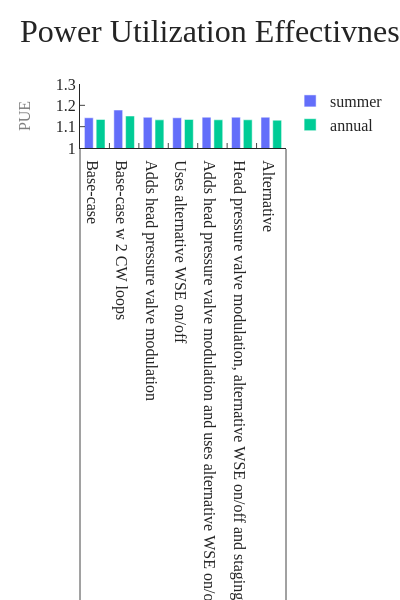

In [28]:
from plotly.offline import iplot, init_notebook_mode

import plotly.graph_objs as go
import plotly.io as pio

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16,
        'color' : "#7f7f7f"}

width = 400
height = 600

title = "Power Utilization Effectivness"


fig = go.Figure()

fig.update_layout(
    template="simple_white",
#         xaxis=dict(title_text="Simulator, Controller Design"),
#         yaxis=dict(title_text="Energy Use [kWh]"),
    barmode="group",
    font=dict(family=font['family'], size=font['size']),
    title=title,
    titlefont=dict(size=font['size'] * 2.0, family=font['family']),
    xaxis=dict(
        title_text="",
        titlefont=dict(
            family=font['family'],
            size=font['size'],
            color=font['color'],
        ),
        tickfont=dict(size=font['size']),
        ticks="inside"
    ),
    yaxis=dict(
        title_text="PUE",
        range=[1,1.3],
        titlefont=dict(
            family=font['family'],
            size=font['size'],
            color=font['color'],
        ),
        tickfont=dict(size=font['size']),
        ticks="inside"
    ),
    showlegend=True,
    width=width,
    height=height,
#         margin=dict(l=margin_l, b=margin_b),
    legend=dict(
#             x=legend_x,
#             y=legend_y,
        font=dict(family=font['family'], size=font['size']),
    ),
)


#     colors = ["#2A66DE", "#FFC32B", "#339933", "#cc9900", "#9933cc"]
colors = ['#636EFA', '#00CC96', '#AB63FA']

# to plot both simulators side by side use 'pue_only' directly 
# in the zip below
pue_single_simulator = pue_only[pue_only["Simulator"] == "dymola"]
pue_single_simulator["Controller Design Label"] = "Controller Design"

for r, c in zip(pue_single_simulator["Season"].unique(), colors):
    plot_df = pue_single_simulator[
        pue_single_simulator["Season"] == r]
#     fig.add_trace(
#         go.Bar(x=[plot_df["Simulator"].apply(
#             lambda x: x.capitalize()), plot_df["Controller Design"].apply(
#               lambda x: x[:-8])], y=plot_df["PUE"], name=r, marker_color=c, width = 0.3),
#     )
    fig.add_trace(
        go.Bar(x=[plot_df["Controller Design Label"], plot_df["Controller Design"]], y=plot_df["PUE"], name=r, marker_color=c, width = 0.3),
    )


img_bytes = fig.to_image(format="png", engine="kaleido")

filename = "pue"

pio.write_image(fig, os.path.join("img", filename + ".png"))

pio.write_image(fig, os.path.join("img", filename + ".pdf"))

from IPython.display import Image
Image(img_bytes)

In [29]:
pue_only

,PUE,Simulator,Controller Design,Season
0,1.14,dymola,Base-case,summer
1,1.18,dymola,Base-case w 2 CW loops,summer
2,1.14,dymola,Adds head pressure valve modulation,summer
3,1.14,dymola,Uses alternative WSE on/off,summer
4,1.14,dymola,Adds head pressure valve modulation and uses a...,summer
5,1.14,dymola,"Head pressure valve modulation, alternative WS...",summer
6,1.14,dymola,Alternative,summer
7,1.13,dymola,Base-case,annual
8,1.15,dymola,Base-case w 2 CW loops,annual
9,1.13,dymola,Adds head pressure valve modulation,annual


# Create plots against an independent variable

## Example to access timeseries results for each variable

In [30]:
# Look at some resulting variables
cases.get_list_of_case_names()
# res['optimica']['test_base'].varNames()
(t, P_agg) = res['dymola']['base_summer'].values("QRooIntGaiAgg.y")
P_agg[-1]

4104000000000.0

## Configure plots

In [31]:
plt.rcParams['axes.facecolor']='whitesmoke'
plt.rcParams['font.size'] = 6
plt.rcParams['text.usetex'] = False
plt.rcParams['legend.facecolor'] = 'white'
plt.rcParams['legend.framealpha'] = 0.75
plt.rcParams['legend.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 300

def save_plot(figure, file_name):
    """ Save the figure to a pdf and png file in the directory `img`
    """
    import os
    import matplotlib.pyplot as plt
    
    out_dir = "img"
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    figure.savefig(os.path.join(out_dir, '{}.pdf'.format(file_name)))
    figure.savefig(os.path.join(out_dir, '{}.png'.format(file_name)))
    plt.clf()
    

def configure_axes(axes):
    """ Configure the axis style
    """
    axes.spines['right'].set_visible(False)
    axes.spines['top'].set_visible(False)
    axes.spines['left'].set_visible(False)
    axes.spines['bottom'].set_visible(False)
    axes.grid(color='lightgrey', linewidth=0.25)
    return


# ---------------------------------------------------------------------------
# helper functions and scripts

def set_cases_and_initiate_plot():
    from matplotlib.gridspec import GridSpec
    cases = ['test_base', 'test_1711']
    seasons = ['']
    num_cases = len(cases)
    num_seasons = len(seasons)
    
    fig = plt.figure(figsize=(6.5,8.))
    gs1 = GridSpec(80, 1)
    gs1.update(left=0.1, right=0.9, hspace=0.05)
    
    ax = list()
    ax.insert(0, fig.add_subplot(gs1[0:11,:]))
    ax.insert(1, fig.add_subplot(gs1[12:23,:]))
    ax.insert(2, fig.add_subplot(gs1[28:39,:]))
    ax.insert(3, fig.add_subplot(gs1[40:51,:]))
    ax.insert(4, fig.add_subplot(gs1[56:67,:]))
    ax.insert(5, fig.add_subplot(gs1[68:79,:]))
    
    # fig, ax = plt.subplots(nrows=num_cases*num_seasons, ncols=1, figsize = (6.5,8.))
    # fig, ax = plt.subplots(nrows=20, ncols=1, figsize = (6.5,8.))
    
    return cases, seasons, num_cases, num_seasons, fig, ax

def set_title(ax, title):
    left, width = .01, .97
    bottom, height = .01, .88
    right = left + width
    top = bottom + height
    
    title_str = r"$\it{" + title + "}$"
    ax.text(left, top,
            title_str,
            verticalalignment = 'center',
            horizontalalignment = 'left', 
            transform=ax.transAxes,
            fontsize = 6, color = 'k',
            bbox=dict(facecolor='white', alpha=0.75, edgecolor='none'))
    
    
def set_up_labels(i, ax, cases, seasons, num_cases, num_seasons, x_axis_label, y_axis_label):
    # Hide xtick labels and ticks on the upper case subplot (each basecase)
    if i % 2 == 0:
        hide_tick_labels(ax)

    # Print x axis title only below the lowest subplot
    if i  == num_cases*num_seasons - 1:
        ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    #ax.xaxis.set_ticks(np.arange(min(t)+0, 365, 1))
     
    # Annotate case
    set_title(ax, cases[i % 2])
    # Annotate case
    # if i % 2 == 0:
    #     title_str = r"$\bf{" + seasons[i/2] + "}$" + ' (upper: ' + r"$\it{" + cases[i % 2] + "}$" + ', lower: ' + r"$\it{"  + cases[(i-1) % 2] + "}$" + ')'
    #     ax.set_title(title_str, # mg assign appropriate season/case
    #                  verticalalignment = 'top',
    #                  horizontalalignment = 'center', 
    #                  fontsize = 6, color = 'k')
        
    # Print legend only at the lower plot (g36 case)
    if i % 1 == 0:
        ax.legend(loc='center right', ncol=1)
    configure_axes(ax)
        
    #plt.tight_layout(h_pad=0)
    plt.tight_layout()
    #plt.subplots_adjust(hspace = .2)
        
def tem_conv_CtoF(T_in_degC):
    '''Converts temperature provided in degC to degF
    '''
    T_in_degF = (T_in_degC)*9./5. + 32.
    
    return T_in_degF

def tem_conv_KtoC(T_in_K):
    '''Converts temperature provided in degC to degF
    '''
    T_in_degC = T_in_K - 273.15
    
    return T_in_degC
        
def add_secondary_yaxis_for_degF(ax, time, temp_in_K):
        # Add a secondary axis with temperatures represented in F
        ax_F = ax.twinx()
        # Get limits to match with the left axis
        ax_F.set_ylim([tem_conv_CtoF(ax.get_ylim()[0]),tem_conv_CtoF(ax.get_ylim()[1])])
        # plot a "scaler" variable and make it invisible
        ax_F.plot(time, tem_conv_CtoF(temp_in_K-273.15), linewidth=0.0)
        ax_F.set_ylabel('temperature [$^\circ$F]')
        configure_axes(ax_F)
        #ax.grid(False)
        #ax.xaxis.grid()
        
def hide_tick_labels(ax):
    '''Removes labels and ticks. Kwargs: bottom controls the ticks, labelbottom the tick labels
    '''
    ax.tick_params(axis = 'x',labelbottom='off',bottom='off')

In [ ]:
from pdb import set_trace as bp

# for a list of variables, using subplots

def plot_vs_independent_variable(
    res_set,
    var_names, 
    ind_var_name = "weaBus.TWetBul", 
    var_legend_labels = [['$test1$', '$test2$'], ['$test3$']], 
    subplot_x_labels = ["subpl 1", "subpl 2"]):
    ''' Plots a scatter of the variables selected in var_names
    against a provided independent variable, ind_var.
    
    Parameters:
    
        res_set : list or one reader object
            List of reader objects with case results, 
            index represents subplot, or one reader
            for all data
     
        var_names : list of lists
            A list of lists of variable names as provided by the reader, 
            for each subplot
            
        ind_var : str
            Name of the independent variable
            
        var_legend_labels : list of lists
            A list of lists for each subplot
            
        subplot_x_labels : list
            A list of x axis labels for each subplot
    '''
    
    font = {'family' : 'serif',
            'weight' : 'normal',
            'size'   : 10}
    
    matplotlib.rc('font', **font)

    n_col = len(var_names)
        
    plt.clf()
    
    if not isinstance(res_set, list):
        res_set = np.repeat(res_set,n_col)
        
    elif not len(res_set) == n_col:
        raise Exception(
            'res_set size mismatch, it should be a list of '\
            'reader objects or a single reader object')
        

    # set the independent variable here, will be taken from the first
    # set or results
    
    ind_var = dict()
    for i in range(n_col):
        (t, ind_var[i]) = res_set[i].values(ind_var_name)
    
        if ".T" in ind_var_name:
            ind_var[i] = tem_conv_KtoC(ind_var[i])
    
    # subplot index
    i = 1
    
    ax = dict()
    
    fig = plt.figure(figsize=(15, 5))
    
    for subplot_var_names in var_names:
        
        v = dict()
        lbl = dict()

        j = 0
        for var in subplot_var_names:

            (t, v[var]) = res_set[i-1].values(var)
            lbl[var] = var_legend_labels[i-1][j]
            
            if ".T" in var:
                v[var] = tem_conv_KtoC(v[var])
                
            j += 1

        # create subplot
        
        ax[i] = fig.add_subplot(1, n_col, i)
        
        for key in v.keys():
            print(lbl[key])
            ax[i].scatter(v[key], ind_var[i-1], label = lbl[key], 
                linewidth=0.5, s = 1.)
            
            ax[i].legend(loc='center right', ncol=1)

        hide_tick_labels(ax[i])

        ax[i].set_xlabel(subplot_x_labels[i - 1])
    
        if i == 1:
            ax[i].set_ylabel('Outdoor air wetbulb temperature [$^\circ$C]')
        
        configure_axes(ax[i])
        
        i += 1
        
        del v
        
    # customize days to display

    #ax.xaxis.set_ticks(np.arange(min(t)+0, 365, 1))

#     ax.set_xlim([min(t), min(t)+24])
#     ax.set_xticks(range(24))
 
    
    
    del ind_var
        
    return plt

# Create the plot for all seasons and cases
fig = plot_vs_independent_variable(res["dymola"]["base_annual"], [["pumCHW.dp_in", "TAirSup.T"], ["pumCHW.m_flow"]], 
                                   var_legend_labels = [["CHW pump dif. pressure", "Air supply temperature"], ["CHW pump flow"]])
save_plot(fig, "test_many")


fig = plot_vs_independent_variable(res["dymola"]["1711_heapreval_annual"], [["TChiWatSupSen.T"], ["TConWatRetSen.T"]], 
                                   var_legend_labels = [["CHW loop temperature [$^\circ$C]"],["CW loop temperature [$^\circ$C]"]])
save_plot(fig, "CWreset_loop_temps")

fig = plot_vs_independent_variable([res["dymola"]["base_annual"],res["dymola"]["1711_wse_annual"]], 
                                   [["waterSideEconomizerOnOff.yOn"], ["yWSEOn.y"]], 
                                   subplot_x_labels = ["base_annual", "1711_wse_annual"],
                                   var_legend_labels = [["WSE on/off signal"],["WSE on/off signal"]])
save_plot(fig, "WSE_on_vs_outdoor_wetbulb")

In [ ]:
from pdb import set_trace as bp

# works for one variable

def plot_vs_independent_variable(
    res_set,
    x_var_name, 
    ind_var_name = "weaBus.TWetBul",
    var_legend_label = 'legend label',
    x_label = "x label",
    y_label = "Outdoor air wetbulb temperature [$^\circ$C]"):
    
    ''' Plots a scatter of x_var_name
    against a provided ind_var_name.
    '''
    
    font = {'family' : 'serif',
            'weight' : 'normal',
            'size'   : 6}
    
    matplotlib.rc('font', **font)
    
    plt.clf()

    # set an independent variable here
    (t, y_var) = res_set.values(ind_var_name)
    (t, x_var) = res_set.values(x_var_name)
    
    if ".T" in ind_var_name:
        y_var = tem_conv_KtoC(y_var)
        
    if ".T" in x_var_name:
        x_var = tem_conv_KtoC(x_var)

    # create subplot

    fig = plt.figure(figsize=(4.5, 4.5))
    ax = fig.add_subplot(1, 1, 1)

    ax.scatter(x_var, y_var, label = var_legend_label, 
        linewidth=0.5, s = 1.)

    hide_tick_labels(ax)

    ax.set_xlabel(x_label)

    ax.set_ylabel(y_label)
        
    # customize days to display

    #ax.xaxis.set_ticks(np.arange(min(t)+0, 365, 1))

#     ax.set_xlim([min(t), min(t)+24])
#     ax.set_xticks(range(24))
 
    ax.legend(loc='center right', ncol=1)

    configure_axes(ax)
    
    del y_var, x_var
        
    return plt

# Create the plot for all seasons and cases
fig = plot_vs_independent_variable(res["dymola"]["base_annual"], "pumCHW.dp_in", "weaBus.TWetBul", x_label = "CHW loop differential pressure [Pa]")
# fig = plot_vs_independent_variable(res["dymola"]["base_annual"], "chilledWaterReset.uChiWatPlaRes", "chilledWaterReset.TChiWatSupSet")
save_plot(fig, "test_one_var_vs_indep")

fig = plot_vs_independent_variable(res["dymola"]["1711_heapreval_annual"], "TChiWatSupSen.T", "weaBus.TWetBul", x_label = "CHW loop temperature [$^\circ$C]")
# fig = plot_vs_independent_variable(res["dymola"]["base_annual"], "chilledWaterReset.uChiWatPlaRes", "chilledWaterReset.TChiWatSupSet")
save_plot(fig, "chw_temp_vs_wetbulb")

fig = plot_vs_independent_variable(res["dymola"]["1711_heapreval_annual"], "TConWatRetSen.T", "weaBus.TWetBul", x_label = "CW loop temperature [$^\circ$C]")
# fig = plot_vs_independent_variable(res["dymola"]["base_annual"], "chilledWaterReset.uChiWatPlaRes", "chilledWaterReset.TChiWatSupSet")
save_plot(fig, "cw_temp_vs_wetbulb")

fig = plot_vs_independent_variable(res["dymola"]["base_annual"], "chilledWaterReset.uChiWatPlaRes", "weaBus.TWetBul", x_label = "CHW reset control signal [1]")
# fig = plot_vs_independent_variable(res["dymola"]["base_annual"], "chilledWaterReset.uChiWatPlaRes", "chilledWaterReset.TChiWatSupSet")
save_plot(fig, "chw_reset_u_vs_wetbulb_base")

In [ ]:
# var_legend_labels = [['$test1$', '$test2$'], '$test3$']
# var_legend_labels[1,1]

# Control diagrams through simulation

In [ ]:
def plot_control_diagram(
    res_set,
    y_var_name,
    sec_y_var_name,
    x_var_name = "weaBus.TWetBul",
    x_legend_label = 'x legend label',
    y_legend_label = 'y legend label',
    x_label = "x label",
    y_label = "y label",
    sec_y_label = "sec y label",
    ):
    
    ''' 
    '''
    
    font = {'family' : 'serif',
            'weight' : 'normal',
            'size'   : 6}
    
    matplotlib.rc('font', **font)
    
    plt.clf()

    # set variables
    (t, x_var) = res_set.values(x_var_name)
    (t, y_var) = res_set.values(y_var_name)
    (t, sec_y_var) = res_set.values(sec_y_var_name)
    print(sec_y_var.mean())
    
    if ".T" in y_var_name:
        y_var = tem_conv_KtoC(y_var)
    
    if ".T" in sec_y_var_name:
        sec_y_var = tem_conv_KtoC(sec_y_var)
    print(sec_y_var.mean())
    print(x_var.mean())
    # create subplot

    fig = plt.figure(figsize=(4.5, 4.5))
    ax = fig.add_subplot(1, 1, 1)

    ax.scatter(x_var, y_var, label = x_legend_label, 
        linewidth=0.5, s = 1.)
    
    ax_2 = ax.twinx()
    # plot a "scaler" variable and make it invisible
    ax_2.scatter(x_var, sec_y_var,  
              label = y_legend_label, linewidth=0.5, s = 1., color = "green")

    hide_tick_labels(ax)
    hide_tick_labels(ax_2)
    
    configure_axes(ax)
    configure_axes(ax_2)
    
    ax_2.set_ylabel(sec_y_label)

    ax.set_xlabel(x_label)

    ax.set_ylabel(y_label)
        
    # customize days to display

    #ax.xaxis.set_ticks(np.arange(min(t)+0, 365, 1))

#     ax.set_xlim([min(t), min(t)+24])
#     ax.set_xticks(range(24))
 
#     ax.legend(loc='center right', ncol=1)
    ax_2.legend(['Right axis'], loc='center right', ncol=1)
    
    del y_var, sec_y_var
        
    return plt


fig = plot_control_diagram(res["dymola"]["base_annual"], 
    "chilledWaterReset.dpChiWatPumSet", "chilledWaterReset.TChiWatSupSet", x_var_name = "chilledWaterReset.uChiWatPlaRes",
    x_label = "CHW reset control signal",
    y_label = "CHW pump differential pressure setpoint [Pa]",
    sec_y_label = "CHW supply temperature setpoint [$^\circ$C]")

save_plot(fig, "base_annual_chw_reset_control_diagram")

fig = plot_control_diagram(res["dymola"]["1711_heapreval_wse_annual"], 
    "chilledWaterReset.dpChiWatPumSet", "chilledWaterReset.TChiWatSupSet", x_var_name = "chilledWaterReset.uChiWatPlaRes",
    x_label = "CHW reset control signal",
    y_label = "CHW pump differential pressure setpoint [Pa]",
    sec_y_label = "CHW loop temperature [$^\circ$C]")

save_plot(fig, "1711_heapreval_wse_annual_chw_reset_control_diagram")

fig = plot_control_diagram(res["dymola"]["1711_heapreval_wse_annual"], 
    "heaPreCon.yMaxTowSpeSet", "heaPreCon.yConWatPumSpeSet", x_var_name = "heaPreCon.chiHeaPreLoo.yHeaPreCon",
    x_label = "CW reset control signal",
    y_label = "Cooling tower fan speed",
    sec_y_label = "CW pump speed")

# save_plot(fig, "1711_heapreval_wse_annual_control_diagram")
save_plot(fig, "1711_heapreval_wse_annual_cw_reset_control_diagram")


fig = plot_control_diagram(res["dymola"]["base_annual"], 
    "chi.TEvaLvg", "chi.TConLvg", x_var_name = "chi.EIRFunT",
    x_label = "Chiller energy input ratio quadratic curve",
    y_label = "CHW Supply Temperature (Evaporator Leaving Water)",
    sec_y_label = "CW Return Temperature (Condenser Leaving Water)")

# save_plot(fig, "1711_heapreval_wse_annual_control_diagram")
save_plot(fig, "base_annual_EIRFunT_vs_evaLea_and_conEnt")

fig = plot_control_diagram(res["dymola"]["1711_all_annual"],
    "towCon.towFanSpe.fanSpeWse.intOpe.loaCon.y", "towCon.towFanSpe.fanSpeWse.wseOpe.chiWatTemCon.y", x_var_name = "cooTow.y",
    x_label = "Tower fan speed",
    y_label = "Minimum chiller capacity control signal (Integrated)",
    sec_y_label = "Chilled water supply temperature control loop (WSE Only)")


save_plot(fig, "1711_annual_tower_fan_control")

# Statistical density plots

In [ ]:
# compare base and alternative controller WSE only and integrated mode 
# as box or violin plots vs. outdoor wetbulb temperature

base = data["dymola"]["base_annual"].copy()
alt = data["dymola"]["1711_all_annual"].copy()

base_int = base[base["chi.on"] == 1.]
base_int = base_int[base_int["waterSideEconomizerOnOff.yOn"] == 1.]
base_int["Design"] = "Base"
base_int["Operation"] = "Integrated"
base_wse = base[base["chi.on"] == 0.]
base_wse = base_wse[base_wse["waterSideEconomizerOnOff.yOn"] == 1.]
base_wse["Design"] = "Base"
base_wse["Operation"] = "WSE Only"

base_int["Wet Bulb Temperature, [$^\circ$C]"] = tem_conv_KtoC(base_int["weaBus.TWetBul"])
base_int1 = base_int.loc[:, ["Operation", "Design", "Wet Bulb Temperature, [$^\circ$C]"]]
base_wse["Wet Bulb Temperature, [$^\circ$C]"] = tem_conv_KtoC(base_wse["weaBus.TWetBul"])
base_wse1 = base_wse.loc[:, ["Operation", "Design", "Wet Bulb Temperature, [$^\circ$C]"]]

alt_int = alt[alt["chi.on"] == 1.]
alt_int = alt_int[alt_int["yWSEOn.y"] == 1.]
alt_int["Design"] = "Alternative"
alt_int["Operation"] = "Integrated"
alt_wse = alt[alt["chi.on"] == 0.]
alt_wse = alt_wse[alt_wse["yWSEOn.y"] == 1.]
alt_wse["Design"] = "Alternative"
alt_wse["Operation"] = "WSE Only"

alt_int["Wet Bulb Temperature, [$^\circ$C]"] = tem_conv_KtoC(alt_int["weaBus.TWetBul"])
alt_int1 = alt_int.loc[:, ["Operation", "Design", "Wet Bulb Temperature, [$^\circ$C]"]]
alt_wse["Wet Bulb Temperature, [$^\circ$C]"] = tem_conv_KtoC(alt_wse["weaBus.TWetBul"])
alt_wse1 = alt_wse.loc[:, ["Operation", "Design", "Wet Bulb Temperature, [$^\circ$C]"]]

plot_df = pd.concat((base_int1, alt_int1,base_wse1, alt_wse1))

plot_df["Operation"].unique()

# Check
print(base[base["chi.on"] == 1.].shape[0]/base.shape[0])
print(alt[alt["chi.on"] == 1.].shape[0]/alt.shape[0])

plot_df.groupby(["Design", "Operation"]).count()/base.shape[0]


In [ ]:
import plotly.express as px

fig = px.box(plot_df, y="Wet Bulb Temperature, [$^\circ$C]", x="Operation", color="Design", 
          hover_data=plot_df.columns)

    
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16,
        'color' : "#7f7f7f"}

fig.update_layout(
    template="simple_white",
#         xaxis=dict(title_text="Season, Controller Design"),
#         yaxis=dict(title_text="Energy Use [kWh]"),
    font=dict(family=font['family'], size=font['size']),
    title="Operation Configuration",
    titlefont=dict(size=font['size'] * 2.0, family=font['family']),
    xaxis=dict(
        titlefont=dict(
            family=font['family'],
            size=font['size'],
            color=font['color'],
        ),
        tickfont=dict(size=font['size']),
    ),
    yaxis=dict(
        title_text="Wet Bulb Temperature [℃]",
        titlefont=dict(
            family=font['family'],
            size=font['size'],
            color=font['color'],
        ),
        tickfont=dict(size=font['size']),
    ),
    showlegend=True,
    width=width,
    height=height,
#         margin=dict(l=margin_l, b=margin_b),
    legend=dict(
        x=0.1,
        y=0.1,
        font=dict(family=font['family'], size=font['size']*.8),
    ),
)

fig.show()

img_bytes = fig.to_image(format="png", engine="kaleido")

filename = "operation_configuration_boxplots"

pio.write_image(fig, os.path.join("img", filename + ".png"))

pio.write_image(fig, os.path.join("img", filename + ".pdf"))

In [ ]:
# For those temperatures in the range 10 -15 degC, where both integrated and WSE only operation configurations exist
# describe the data

int_overlap = alt_int[(alt_int["Wet Bulb Temperature, [$^\circ$C]"] > 10)]
int_overlap = int_overlap[(int_overlap["Wet Bulb Temperature, [$^\circ$C]"] < 15)]

wse_overlap = alt_wse[(alt_wse["Wet Bulb Temperature, [$^\circ$C]"] > 10)]
wse_overlap = wse_overlap[(wse_overlap["Wet Bulb Temperature, [$^\circ$C]"] < 15)]

print("Integrated: \n\n", int_overlap.describe().round(2))

In [ ]:
print("WSE: \n\n", wse_overlap.describe().round(2))

In [ ]:
wse_overlap.head()

## Chiller performance checks

In [ ]:
# aggregate data timeseries
chi_dat = dict()
chi_dat = {"dymola": dict()}
simulators = ["dymola"]
for simulator in simulators:
    for case in ["base_annual"]:
        chi_dat[simulator][case] = get_partial_results(
            case,  ["chi.EIRFunT", "chi.capFunT","chi.TEvaLvg", "chi.TConLvg", "chi.on", "chi.P","chi.PLR1","chi.PLR2"], 
            simulator, as_dataframe=True, equidistant = simulator == "dymola")
        chi_dat[simulator][case] = chi_dat[simulator][case].loc[(chi_dat[simulator][case].index % 2)==0,:].reset_index(drop=True)
chi = chi_dat["dymola"]["base_annual"]

chi.head()

chi = chi[chi.columns.drop(list(chi.filter(regex='time_')))]

chi_on = chi[chi["chi.on"] == 1.]
print("base:\n\n", chi_on.describe())



In [ ]:
print("1711:\n\n", chi_1711_on.describe())

In [ ]:
chi_1711_dat = dict()
chi_1711_dat = {"dymola": dict()}
simulators = ["dymola"]
for simulator in simulators:
    for case in ["1711_all_annual"]:
        chi_1711_dat[simulator][case] = get_partial_results(
            case,  ["chi.EIRFunT", "chi.capFunT","chi.TEvaLvg", "chi.TConLvg", "chi.on", "chi.P","chi.PLR1","chi.PLR2"], 
            simulator, as_dataframe=True, equidistant = simulator == "dymola")
        chi_1711_dat[simulator][case] = chi_1711_dat[simulator][case].loc[(chi_1711_dat[simulator][case].index % 2)==0,:].reset_index(drop=True)
chi_1711 = chi_1711_dat["dymola"]["1711_all_annual"]

chi_1711.head()

chi_1711 = chi_1711[chi_1711.columns.drop(list(chi_1711.filter(regex='time_')))]

chi_1711_on = chi_1711[chi_1711["chi.on"] == 1.]


In [ ]:
check_p = chi_on[chi_on["chi.TEvaLvg"] >= chi_on["chi.TConLvg"]]
check_p["lift"] = -check_p["chi.TEvaLvg"].subtract(chi_on["chi.TConLvg"])
check_p.sort_values("lift", ascending = False)

check_p.describe()

In [ ]:
# 3d plot to check chiller performance outside of the usual range (at low lift region)

# res["dymola"]["1711_heapreval_annual"].varNames()
#  (t, sec_y_var) = res["dymola"]["1711_heapreval_annual"].values("chilledWaterReset.TChiWatSupSet")
# (t, x_var) = res["dymola"]["base_annual"].values("chi.EIRFunT")
# (t, y_var) = res["dymola"]["base_annual"].values("chi.TEvaLvg")
# (t, sec_y_var) = res["dymola"]["base_annual"].values("chi.TConEnt")
# plt.contour([y_var, sec_y_var], x_var, [10, 30, 50])

y_var = chi_on["chi.TEvaLvg"].values
sec_y_var = chi_on["chi.TConLvg"].values
x_var = chi_on["chi.EIRFunT"].values

from mpl_toolkits import mplot3d

ax = plt.axes(projection='3d')

sec_y_var = tem_conv_KtoC(sec_y_var)
y_var = tem_conv_KtoC(y_var)

fig = ax.scatter3D(y_var, sec_y_var, x_var, c=x_var,cmap='viridis', marker = '.', linewidth=0.5) 

ax.set_xlabel('CHW Supply Temperature (Evaporator Leaving Water)')
ax.set_ylabel('CW Return Temperature (Condenser Leaving Water)')
ax.set_zlabel('Chiller energy input ratio quadratic curve')

save_plot(plt, "Base - Chiller energy input ratio quadratic curve_3d")


y_var = chi_1711_on["chi.TEvaLvg"].values
sec_y_var = chi_1711_on["chi.TConLvg"].values
x_var = chi_1711_on["chi.EIRFunT"].values

ax = plt.axes(projection='3d')

sec_y_var = tem_conv_KtoC(sec_y_var)
y_var = tem_conv_KtoC(y_var)

fig = ax.scatter3D(y_var, sec_y_var, x_var, c=x_var,cmap='viridis', marker = '.', linewidth=0.5) 

ax.set_xlabel('CHW Supply Temperature (Evaporator Leaving Water)')
ax.set_ylabel('CW Return Temperature (Condenser Leaving Water)')
ax.set_zlabel('Chiller energy input ratio quadratic curve')

save_plot(plt, "1711 - Chiller energy input ratio quadratic curve_3d")

# check capFunT

y_var = chi_1711_on["chi.TEvaLvg"].values
sec_y_var = chi_1711_on["chi.TConLvg"].values
x_var = chi_1711_on["chi.capFunT"].values

ax = plt.axes(projection='3d')

sec_y_var = tem_conv_KtoC(sec_y_var)
y_var = tem_conv_KtoC(y_var)

fig = ax.scatter3D(y_var, sec_y_var, x_var, c=x_var,cmap='viridis', marker = '.', linewidth=0.5) 

ax.set_xlabel('CHW Supply Temperature (Evaporator Leaving Water)')
ax.set_ylabel('CW Return Temperature (Condenser Leaving Water)')
ax.set_zlabel('Cooling capacity factor function of temperature curve')

save_plot(plt, "1711 - Cooling capacity factor function of temperature curve_3d")

y_var = chi_on["chi.TEvaLvg"].values
sec_y_var = chi_on["chi.TConLvg"].values
x_var = chi_on["chi.capFunT"].values

ax = plt.axes(projection='3d')

sec_y_var = tem_conv_KtoC(sec_y_var)
y_var = tem_conv_KtoC(y_var)

fig = ax.scatter3D(y_var, sec_y_var, x_var, c=x_var,cmap='viridis', marker = '.', linewidth=0.5) 

ax.set_xlabel('CHW Supply Temperature (Evaporator Leaving Water)')
ax.set_ylabel('CW Return Temperature (Condenser Leaving Water)')
ax.set_zlabel('Cooling capacity factor function of temperature curve')

save_plot(plt, "Base - Cooling capacity factor function of temperature curve_3d")

# Timeseries plots

## Chiller plant - power

*mg adjust this method to take various cases as needed

In [ ]:
def plot_power(res_set):
    ''' Main method that plots the results
    '''
    font = {'family' : 'serif',
            'weight' : 'normal',
            'size'   : 6}
    matplotlib.rc('font', **font)
    
    plt.clf()
    
    time_scale=3600.
       
    (t, pumCHW_P) = res_set.values("pumCHW.P")
    (t, pumCW_P) = res_set.values("pumCW.P")
    (t, chi_P) = res_set.values("chi.P")
    t = t/time_scale
   
    # Plot figure
    fig = plt.figure(figsize=(6.5, 2.5))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(t, pumCHW_P, label = '$P_{chw,p}$', linewidth=0.5)
         
    # make_ticklabels_invisible(plt.gcf())
        
    # customize days to display

    ax.set_xlabel('time [h]')
    ax.set_ylabel('Chiller water pump power [W]')
    #ax.xaxis.set_ticks(np.arange(min(t)+0, 365, 1))

    ax.set_xlim([min(t), min(t)+24])
    ax.set_xticks(range(24))
 
    ax.legend(loc='center right', ncol=1)

    configure_axes(ax)
        
    return plt

# Create the plot for all seasons and cases
fig = plot_power(res["dymola"]["base_annual"])
save_plot(fig, "CHWpum_P")

In [ ]:
res['optimica'].keys()

## Outside conditions

In [ ]:
def plot_outside(res_set):
    # ------------------------------------------------------
    plt.clf()
    plt.ylim([0., 20.])
    time_scale=86400.
    # ------------------------------------------------------
    
    ax = list()
    # get a list of unique climate cases
    unique_climate_cases = list(res_set.keys())[0] # all in the same climate
    
    subplot_id = 0
    for climate in unique_climate_cases:
        (t, TOut) = res_set[case_name].values("weaBus.TDryBul")
        (t, TOutWet) = res_set[case_name].values("weaBus.TWetBul")
        
        t = t/time_scale
        
        # Generate figure and plot data
        ax.insert(subplot_id, plt.subplot(len(unique_climate_cases)*2, 1, subplot_id+1))
        
        for subplot_id in [0,2,4]:
            ax[subplot_id].plot(t, TOut-273.15, 'r', \
                   label='$T_{oa}$', linewidth=0.5)
            ax[subplot_id].set_ylabel('temperature [$^\circ$C]')
            add_secondary_yaxis_for_degF(ax[subplot_id], t, TOut)
            set_title(ax[subplot_id], '$T_{oa}$')
        
        subplot_id += 1
        
        for subplot_id in [1,3,5]:
            ax[subplot_id].plot(t, TOutWet-273.15, 'r', \
                   label='$T_{oa,w}$', linewidth=0.5)
            ax[subplot_id].set_ylabel('temperature [$^\circ$C]')
            add_secondary_yaxis_for_degF(ax[subplot_id], t, TOutWet)
            set_title(ax[subplot_id], '$T_{oa,w}$')
        
        # customize days to display
        ax[subplot_id].set_xlim([min(t)+5, min(t)+10])

        configure_axes(ax[subplot_id])
        ax[subplot_id].legend(loc='center right', ncol=1)
        
        subplot_id += 1

#     ax[5].set_xlabel('time [days]')

    return plt

# Create the plot for all seasons and cases
fig = plot_outside(res["dymola"])
save_plot(fig, "outside")

cases.get_list_of_case_names()
